## Construindo o Racional de Modelo Híbrido (Reg. Linear + XGBoost)

In [88]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import numpy as np
from math import sqrt

# Configurações de visualizações
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [89]:
# Carrega dados originais do Bacen
df_bacen = pd.read_excel('Instrumentos de Pagamento - Dados Estatisticos.xlsx', sheet_name="6.3", header=2)
# Extrai array com volume de boletos intrabancários movimentos por ano (Bilhões)
array_bol_intra = df_bacen[df_bacen['Valor (R$ bilhões)'] == 'Boleto de pagamento'].iloc[0,19:].reset_index(drop=True).values
# Extrai array com ano dos volumes de boletos intrabancários movimentos
array_ano = df_bacen[df_bacen['Valor (R$ bilhões)'].isnull()].iloc[0,19:].reset_index(drop=True).values
# Cria dataframe contendo ano e volume de boleto intrabancário movimentado
df_bol_intra = pd.DataFrame({'Ano': array_ano, 'Boleto Intrabancario': array_bol_intra})
# Transforma colunas para os tipos adequados
df_bol_intra['Boleto Intrabancario'] = pd.to_numeric(df_bol_intra['Boleto Intrabancario'])
df_bol_intra['Ano'] = pd.to_numeric(df_bol_intra['Ano'])
df_bol_intra['Ano'] = pd.to_datetime(df_bol_intra['Ano'], format='%Y')
# Ordena dataframe por Ano
df_bol_intra = df_bol_intra.sort_values(by='Ano').set_index('Ano')
# Imprime dataframe
display(df_bol_intra)

,Boleto Intrabancario
Ano,
2011-01-01,1045.85
2012-01-01,1191.92
2013-01-01,1330.85
2014-01-01,1504.02
2015-01-01,1484.98
2016-01-01,1424.93
2017-01-01,1459.45
2018-01-01,2156.93
2019-01-01,2431.50


In [90]:
janela_de_previsao = 2 # em anos
janela_De_treinamento = 4 # em anos
ano_corte_lim_sup = 2021 # ano

order_n = 1

df_bol_intra_modelagem = df_bol_intra[df_bol_intra.index <= str(ano_corte_lim_sup)]

# y = df_bol_intra_modelagem[df_bol_intra_modelagem.index <= str(ano_corte_lim_sup)].copy()
y = df_bol_intra_modelagem[(df_bol_intra_modelagem.index > df_bol_intra_modelagem.index.max() - pd.DateOffset(years=janela_de_previsao+janela_De_treinamento))].copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=order_n,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=janela_de_previsao, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# # Plot
# axs = y_train.plot(color='0.25', subplots=True, sharex=True)
# axs = pd.concat([y_train[y_train.index == y_train.index[-1]],y_test]).plot(color='0.25', subplots=True, sharex=True, ax=axs)
# axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
# axs = pd.concat([y_fit[y_fit.index == y_fit.index[-1]],y_pred]).plot(color='C3', subplots=True, sharex=True, ax=axs)
# for ax in axs: ax.legend([])
# _ = plt.suptitle("Trends")

In [91]:
# Adequando dataset para utilizando no algoritimo XGboost
X = df_bol_intra_modelagem.copy()

# Label encoding for annual seasonality
X["Ano"] = X.index.year

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit.values.T # Com isso conseguirmos verificar o quão bom foi o fit do modelo
y_pred_boosted = xgb.predict(X_test) + y_pred.values.T # Aqui verificamos os valores previstos finais

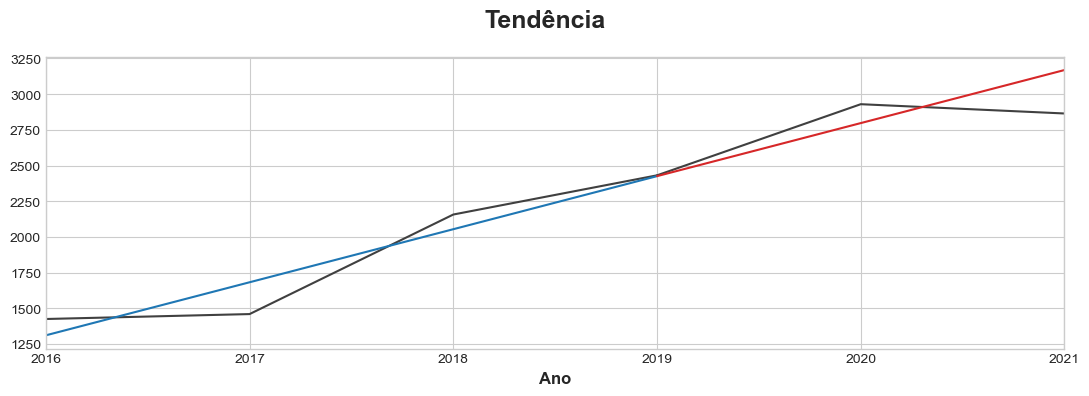

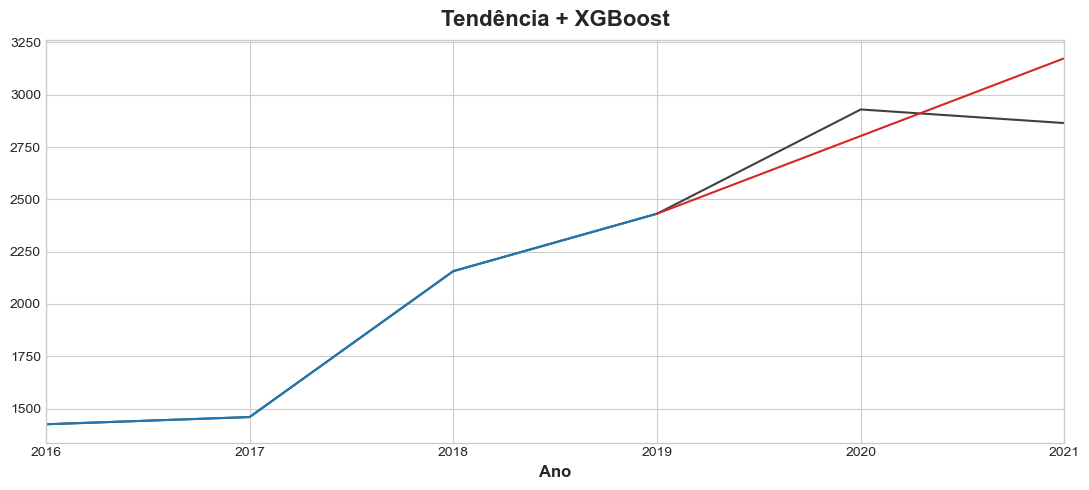

In [92]:
# Transforma resultados do XGboost para dataframe
df_y_fit_boosted = pd.DataFrame(
                        index = y_train.index,
                        data = y_fit_boosted[0],
                        columns= ['Boleto Intrabancario'])

df_y_pred_boosted = pd.DataFrame(
                        index = y_test.index,
                        data = y_pred_boosted[0],
                        columns= ['Boleto Intrabancario'])

# Plota resultados | Linear
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = pd.concat([y_train[y_train.index == y_train.index[-1]],y_test]).plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = pd.concat([y_fit[y_fit.index == y_fit.index[-1]],y_pred]).plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Tendência")

# Plota resultados | Linear + XGBoost
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['Tendência + XGBoost'],
)
axs = pd.concat([y_train[y_train.index == y_train.index[-1]],y_test]).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = df_y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = pd.concat([df_y_fit_boosted[df_y_fit_boosted.index == df_y_fit_boosted.index[-1]],df_y_pred_boosted]).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

In [93]:
# Dataframe de métrica de treino
df_train_metrica = (pd.merge(y_train, df_y_fit_boosted, 
                        how='left', 
                        left_on=y_train.index, 
                        right_on=df_y_fit_boosted.index).
                    rename({'key_0':'Ano', 
                            'Boleto Intrabancario_x':'y_train',
                            'Boleto Intrabancario_y':'y_fit'},
                        axis=1))
df_train_metrica['erro'] = round(df_train_metrica.y_fit - df_train_metrica.y_train,3)

# Dataframe de métricas de teste
df_test_metrica = (pd.merge(y_test, df_y_pred_boosted, 
                        how='left', 
                        left_on=y_test.index, 
                        right_on=df_y_pred_boosted.index).
                    rename({'key_0':'Ano', 
                            'Boleto Intrabancario_x':'y_test',
                            'Boleto Intrabancario_y':'y_fit'},
                        axis=1))
df_test_metrica['erro'] = round(df_test_metrica.y_fit - df_test_metrica.y_test,3)
df_test_metrica['erro_%'] = round((df_test_metrica.y_fit / df_test_metrica.y_test - 1)*100,1)
df_test_metrica['order_model_linear'] = order_n

print('df_train_metrica:')
display(df_train_metrica)
# print(f'df_test_metrica: (janela de {janela_De_treinamento} anos)')
print(f'df_test_metrica: (Trainamento até {df_train_metrica.Ano.dt.year.max()})')
display(df_test_metrica)

df_train_metrica:


,Ano,y_train,y_fit,erro
0,2016-01-01,1424.93,1424.93,-0.00
1,2017-01-01,1459.45,1459.45,0.00
2,2018-01-01,2156.93,2156.93,-0.00
3,2019-01-01,2431.50,2431.50,0.00


df_test_metrica: (Trainamento até 2019)


,Ano,y_test,y_fit,erro,erro_%,order_model_linear
0,2020-01-01,2929.86,2803.22,-126.64,-4.30,1
1,2021-01-01,2864.77,3174.94,310.17,10.80,1


**Resultado para janela de 3 Anos:**

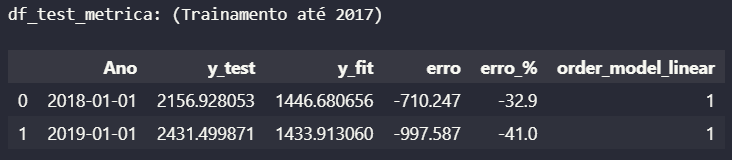

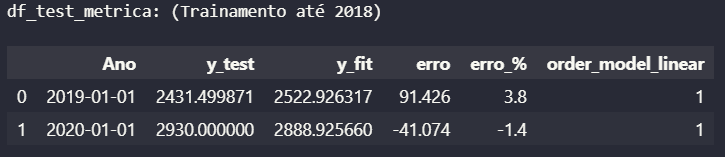

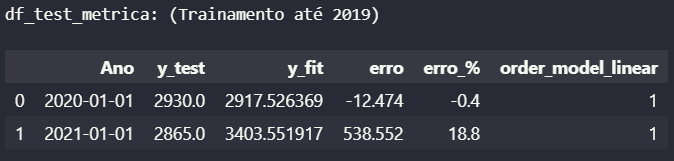

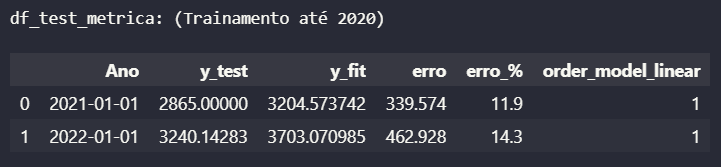

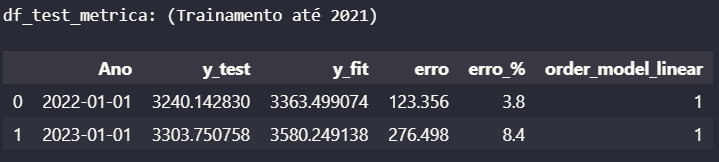

**Resultado para janela de 7 Anos:** <mark>(Ainda se sai melhor do que uma janela de 3 meses, por exemplo)

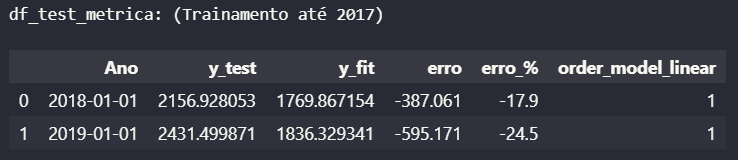

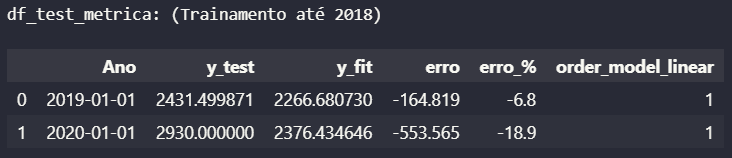

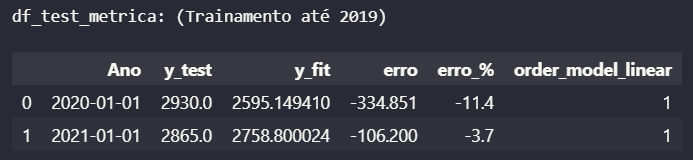

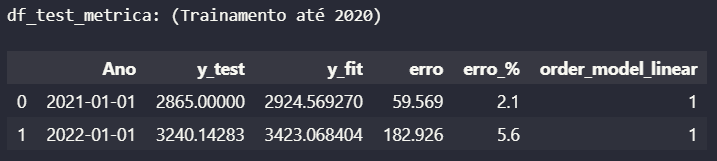

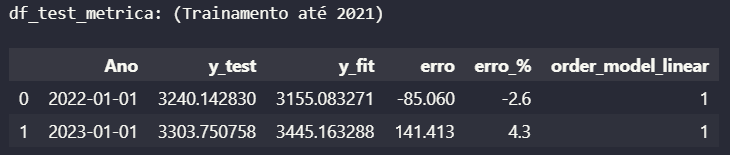


**Resultado para diferentes janelas de treinamento: (Dados até 2023)**

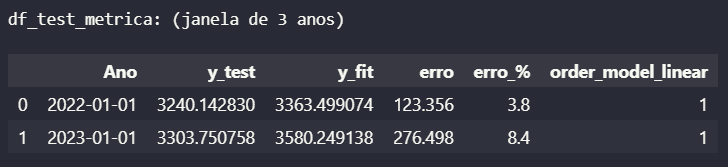

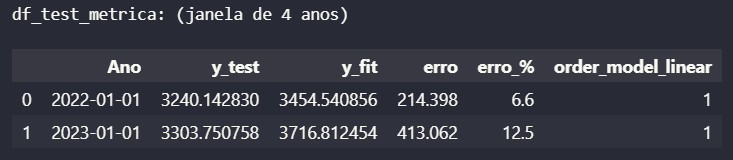

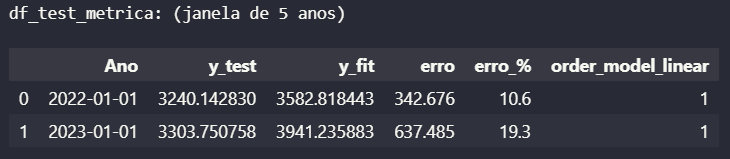

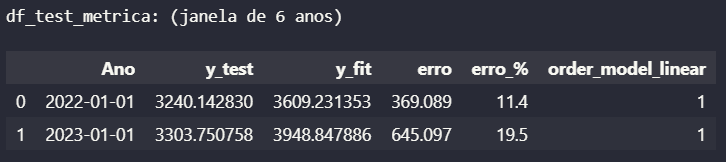

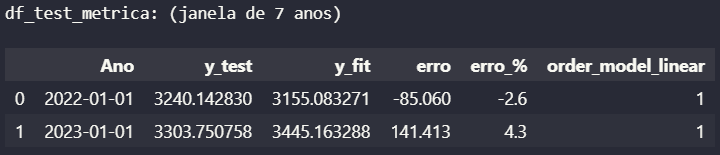

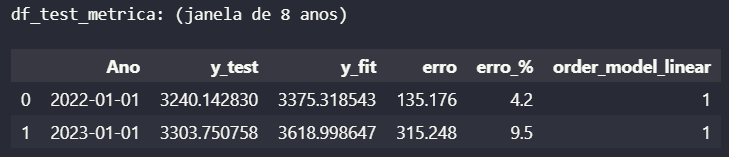

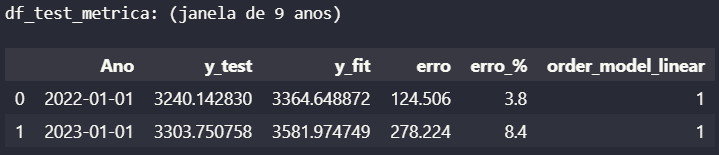

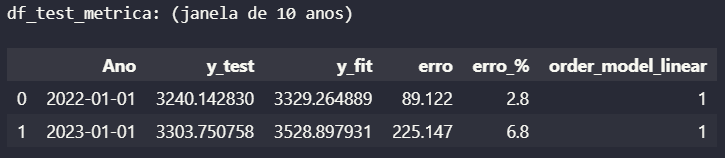

**Resultado para diferentes janelas de treinamento: (Dados até 2022)**

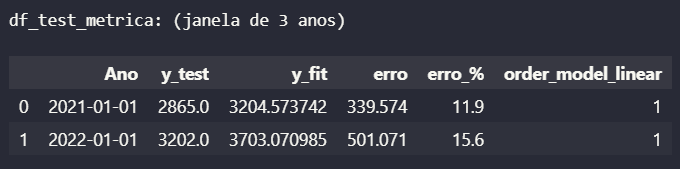

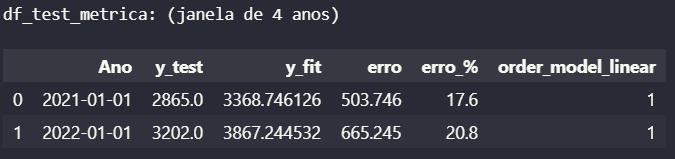

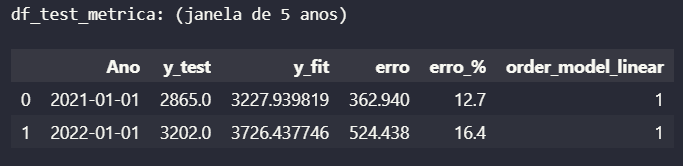

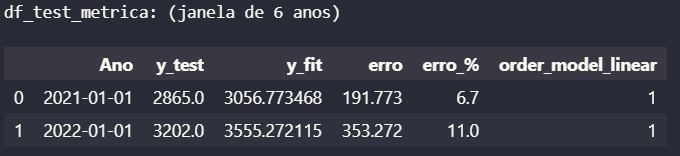

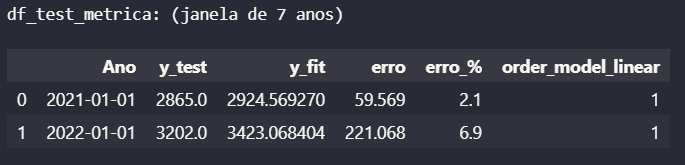

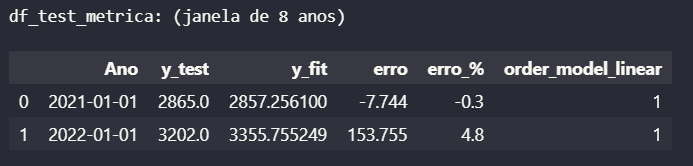

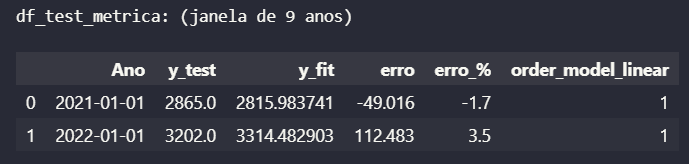

## Avaliando diferente cenários (Modelo Híbrido)

In [94]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import numpy as np


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

df_bol_intra = pd.read_excel('intrabancario_bacen.xlsx', 
                          usecols=['Ano','Boleto Intrabancario'], 
                          parse_dates=['Ano'], 
                          index_col='Ano')

# df_bol_intra.head()

In [95]:
def realiza_precicao_hibirida(dataframe, ano_corte_treino=2021, order_n=2):

    y = dataframe[dataframe.index < str(ano_corte_treino)].copy()

    # Create trend features
    dp = DeterministicProcess(
        index=y.index,  # dates from the training data
        constant=True,  # the intercept
        order=order_n,        # quadratic trend
        drop=True,      # drop terms to avoid collinearity
    )
    X = dp.in_sample()  # features for the training data

    # Test on the years 2016-2019. It will be easier for us later if we
    # split the date index instead of the dataframe directly.
    idx_train, idx_test = train_test_split(
        y.index, test_size= 2, shuffle=False,
    )
    X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]

    # Fit trend model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Make predictions
    y_fit = pd.DataFrame(
        model.predict(X_train),
        index=y_train.index,
        columns=y_train.columns,
    )
    y_pred = pd.DataFrame(
        model.predict(X_test),
        index=y_test.index,
        columns=y_test.columns,
    )

    # Adequando dataset para utilizando no algoritimo XGboost
    X = dataframe

    # Label encoding for annual seasonality
    X["Ano"] = X.index.year

    # Create splits
    X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]
    # Create residuals (the collection of detrended series) from the training set
    y_resid = y_train - y_fit

    # Train XGBoost on the residuals
    xgb = XGBRegressor()
    xgb.fit(X_train, y_resid)

    # Add the predicted residuals onto the predicted trends
    y_fit_boosted = xgb.predict(X_train) + y_fit.values.T
    y_pred_boosted = xgb.predict(X_test) + y_pred.values.T

    # Transforma resultados do XGboost para dataframe
    df_y_fit_boosted = pd.DataFrame(
                            index = y_train.index,
                            data = y_fit_boosted[0],
                            columns= ['Boleto Intrabancario'])

    df_y_pred_boosted = pd.DataFrame(
                            index = y_test.index,
                            data = y_pred_boosted[0],
                            columns= ['Boleto Intrabancario'])

    # Dataframe de métrica de treino
    df_train_metrica = (pd.merge(y_train, df_y_fit_boosted, 
                            how='left', 
                            left_on=y_train.index, 
                            right_on=df_y_fit_boosted.index).
                        rename({'key_0':'Ano', 
                                'Boleto Intrabancario_x':'y_train',
                                'Boleto Intrabancario_y':'y_fit'},
                            axis=1))
    df_train_metrica['erro'] = round(df_train_metrica.y_fit - df_train_metrica.y_train,3)

    # Dataframe de métricas de teste
    df_test_metrica = (pd.merge(y_test, df_y_pred_boosted, 
                            how='left', 
                            left_on=y_test.index, 
                            right_on=df_y_pred_boosted.index).
                        rename({'key_0':'Ano', 
                                'Boleto Intrabancario_x':'y_test',
                                'Boleto Intrabancario_y':'y_pred'},
                            axis=1))
    df_test_metrica['erro'] = round(df_test_metrica.y_pred - df_test_metrica.y_test,3)
    df_test_metrica['erro_%'] = round((df_test_metrica.y_pred / df_test_metrica.y_test - 1)*100,1)
    df_test_metrica['order_model_linear'] = order_n

    return df_train_metrica, df_test_metrica

In [96]:
# Treina modelos e gera resultados

# Treinando até 2018
df_train_metrica_1a, df_test_metrica_1a = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2021, order_n=1)

df_train_metrica_2a, df_test_metrica_2a = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2021, order_n=2)

df_train_metrica_3a, df_test_metrica_3a = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2021, order_n=3)

# Treinando até 2019
df_train_metrica_1b, df_test_metrica_1b = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2022, order_n=1)

df_train_metrica_2b, df_test_metrica_2b = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2022, order_n=2)

df_train_metrica_3b, df_test_metrica_3b = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2022, order_n=3)

# Treinando até 2020
df_train_metrica_1c, df_test_metrica_1c = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2023, order_n=1)

df_train_metrica_2c, df_test_metrica_2c = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2023, order_n=2)

df_train_metrica_3c, df_test_metrica_3c = realiza_precicao_hibirida(df_bol_intra.copy(), ano_corte_treino=2023, order_n=3)

In [97]:
# Visualiza resultados
# print('df_train_metrica_1a:') ; display(df_train_metrica_1a)
# print('df_train_metrica_2a:') ; display(df_train_metrica_2a)
# print('df_train_metrica_3a:') ; display(df_train_metrica_3a)

print('\033[0;1;40mTreinamento realizado até 2018\033[m\n')

print('df_test_metrica_1a:') ; display(df_test_metrica_1a)
print('df_test_metrica_2a:') ; display(df_test_metrica_2a)
print('df_test_metrica_3a:') ; display(df_test_metrica_3a)

Treinamento realizado até 2018

df_test_metrica_1a:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2019-01-01,2431.50,2268.57,-162.93,-6.70,1
1,2020-01-01,2930.00,2380.22,-549.78,-18.80,1


df_test_metrica_2a:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2019-01-01,2431.50,2357.07,-74.43,-3.10,2
1,2020-01-01,2930.00,2579.34,-350.66,-12.00,2


df_test_metrica_3a:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2019-01-01,2431.50,2932.08,500.58,20.60,3
1,2020-01-01,2930.00,4127.43,1197.43,40.90,3


In [98]:
# # Visualiza resultados
# print('df_train_metrica_1b:') ; display(df_train_metrica_1b)
# print('df_train_metrica_2b:') ; display(df_train_metrica_2b)
# print('df_train_metrica_3b:') ; display(df_train_metrica_3b)

print('\033[0;1;40mTreinamento realizado até 2019\033[m\n')

print('df_test_metrica_1b:') ; display(df_test_metrica_1b)
print('df_test_metrica_2b:') ; display(df_test_metrica_2b)
print('df_test_metrica_3b:') ; display(df_test_metrica_3b)

Treinamento realizado até 2019

df_test_metrica_1b:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2020-01-01,2930.00,2575.09,-354.91,-12.10,1
1,2021-01-01,2865.00,2718.69,-146.31,-5.10,1


df_test_metrica_2b:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2020-01-01,2930.00,2760.10,-169.90,-5.80,2
1,2021-01-01,2865.00,3129.80,264.81,9.20,2


df_test_metrica_3b:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2020-01-01,2930.00,3243.99,313.99,10.70,3
1,2021-01-01,2865.00,4392.64,1527.64,53.30,3


In [99]:
# Visualiza resultados (treino até 2020)
# print('df_train_metrica_1c:') ; display(df_train_metrica_1c)
# print('df_train_metrica_2c:') ; display(df_train_metrica_2c)
# print('df_train_metrica_3c:') ; display(df_train_metrica_3c)

print('\033[0;1;40mTreinamento realizado até 2020\033[m\n')

print('df_test_metrica_1c:') ; display(df_test_metrica_1c)
print('df_test_metrica_2c:') ; display(df_test_metrica_2c)
print('df_test_metrica_3c:') ; display(df_test_metrica_3c)

Treinamento realizado até 2020

df_test_metrica_1c:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2021-01-01,2865.00,2789.94,-75.06,-2.60,1
1,2022-01-01,3240.14,3288.44,48.29,1.50,1


df_test_metrica_2c:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2021-01-01,2865.00,3272.94,407.94,14.20,2
1,2022-01-01,3240.14,3878.78,638.63,19.70,2


df_test_metrica_3c:


,Ano,y_test,y_pred,erro,erro_%,order_model_linear
0,2021-01-01,2865.00,3912.84,1047.84,36.60,3
1,2022-01-01,3240.14,4926.25,1686.11,52.00,3


Avaliando RMSE dos modelos em todo o perído de testes:

In [100]:
df_predict_order_1 = pd.concat([df_test_metrica_1a,df_test_metrica_1b,df_test_metrica_1c])
rmse_order_1 = sqrt(mean_squared_error(df_predict_order_1['y_test'], df_predict_order_1['y_pred']))

df_predict_order_2 = pd.concat([df_test_metrica_2a,df_test_metrica_2b,df_test_metrica_2c])
rmse_order_2 = sqrt(mean_squared_error(df_predict_order_2['y_test'], df_predict_order_2['y_pred']))

df_predict_order_3 = pd.concat([df_test_metrica_3a,df_test_metrica_3b,df_test_metrica_3c])
rmse_order_3 = sqrt(mean_squared_error(df_predict_order_3['y_test'], df_predict_order_3['y_pred']))

pd.DataFrame(
{'Modelo' : ['RMSE Linear Order 1 + XGBoost','RMSE Linear Order 2 + XGBoost','RMSE Linear Order 3 + XGBoost'],
 'RMSE' : [rmse_order_1, rmse_order_2, rmse_order_3]}).sort_values('RMSE')

NameError: name 'mean_squared_error' is not defined

**Conclusão:** Nosso melhor modelo foi a composição de (considerando treino até 2019):
    - Regressão linear de ordem 1
    - XGBoost (sem tunning de parâmetros)
    - Desconsiderando features auxliares

**OBS:** Vale lembrar que o BACEN tem uma defasagem de quase 2 anos para aliberação dos dados intrabancário, portanto o treino deve ser realiza até no máximo 2 períodos anterios ao período que desejamos prever

**ReferÊncia utilizada:** https://www.kaggle.com/code/ryanholbrook/hybrid-models/tutorial

## Possíveis melhorias

1) Realizar Cross Validation (visto que temos um pequena quantidade de dados)
2) Utilizar variáveis exógenas (ex: série temporais de outros produtos ou lags da prória variável)
3) Realizar tunning de hiperparâmetros do modelo XGBoost

## Mèdia Móveis